#Питоновская реализация EM алгоритма

Полезно проделать, чтобы разобраться в numpy и в том, как эффективно писать на питоне.

In [1]:
import numpy as np
import scipy
import scipy.sparse
from sklearn.datasets import fetch_20newsgroups
import gensim
from collections import Counter
import heapq
import nltk
from nltk.corpus import stopwords
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

/usr/share/python/yandex-ydf-toolbox/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Нужно скачать некоторые коллекции данных и установить библиотеки (nltk, gensim)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/tylorn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
english_stopwords = set(stopwords.words('english'))

## Исходники, можно пропускать

In [4]:
def trivial_p_dwt_processor(p_dwt):
    pass

def create_frac_of_max_p_dwt_processor(frac_size):
    def fun(p_dwt):
        maximums = np.max(p_dwt, axis=1)
        p_dwt[p_dwt < frac_size * maximums[:, np.newaxis]] = 0.
        p_dwt /= (np.sum(p_dwt, axis=1)[:, np.newaxis] + 1e-10)
    return fun

In [5]:
def perform_e_step_update(it_num, freq_matrix, docptr, phi_matrix, theta_matrix, params):
    block_size = params.get('block_size', 1)
    p_dwt_processor = params.get('p_dwt_processor', lambda x: None)
    event_handler = params.get('event_handler', EmptyHandler())
    
    D, W = freq_matrix.shape
    T = phi_matrix.shape[0]
    n_wt, n_dt = np.zeros((W, T)), np.zeros((D, T))
    transposed_phi_matrix = np.transpose(phi_matrix)
    
    indices = freq_matrix.indices
    indptr = freq_matrix.indptr
    data = freq_matrix.data
    
    for block_num in xrange((D + block_size - 1) / block_size):
        block_start = block_num * block_size
        block_finish = min(D, block_start + block_size)
        ind_start, ind_finish = indptr[block_start], indptr[block_finish]
        
        datas = data[ind_start:ind_finish]
        words = indices[ind_start:ind_finish]
        docs = docptr[ind_start:ind_finish]
        
        p_dwt = transposed_phi_matrix[words] * theta_matrix[docs, :]
        p_dwt /= (np.sum(p_dwt, axis=1)[:, np.newaxis] + 1e-20)
        p_dwt_processor(p_dwt)
        p_dwt *= datas[:, np.newaxis]
        
        for doc_num in xrange(block_start, block_finish):
            doc_start, doc_finish = indptr[doc_num], indptr[doc_num + 1]
            doc_p_dwt = p_dwt[(doc_start - ind_start):(doc_finish - ind_start), :]
            n_dt[doc_num, :] += np.sum(doc_p_dwt, axis=0)
            n_wt[indices[doc_start:doc_finish], :] += doc_p_dwt
            
    event = {
        'n_wt': n_wt,
        'n_dt': n_dt,
        'freq_matrix': freq_matrix,
        'phi_matrix': phi_matrix,
        'theta_matrix': theta_matrix,
        'docptr': docptr,
        'it_num': it_num
    }
    event_handler.handle(event)

    return n_wt, n_dt

In [6]:
def launch_em(
    freq_matrix, 
    phi_matrix,
    theta_matrix,
    regularizations_list,
    params_list,
    iters_count=100
):
    phi_matrix = np.copy(phi_matrix)
    theta_matrix = np.copy(theta_matrix)
    docptr = []
    indptr = freq_matrix.indptr
    for doc_num in xrange(D):
        docptr.extend([doc_num] * (indptr[doc_num + 1] - indptr[doc_num]))
    docptr = np.array(docptr)
    
    for it in xrange(iters_count):
        n_wt, n_dt = params_list[it]['method'](it, freq_matrix, docptr, phi_matrix, theta_matrix, params_list[it])
        r_wt, r_dt = regularizations_list[it](n_wt, n_dt, phi_matrix, theta_matrix)
        n_wt = np.maximum(n_wt + r_wt, 0)
        n_dt = np.maximum(n_dt + r_dt, 0)
        n_wt /= np.sum(n_wt, axis=0)
        n_dt /= np.sum(n_dt, axis=1)[:, np.newaxis]
        phi_matrix = np.transpose(n_wt)
        theta_matrix = n_dt
        
    return phi_matrix, theta_matrix

In [125]:
def trivial_regularization(n_wt, n_dt, phi_matrix, theta_matrix):
    return 0., 0.

def calculate_decorr(phi_matrix):
    aggr_phi = np.sum(phi_matrix, axis=1)
    return np.sum(phi_matrix * (aggr_phi[:, np.newaxis] - phi_matrix))

def create_reg_decorr_naive(tau, theta_alpha=0.):
    def fun (n_wt, n_dt, phi_matrix, theta_matrix):
        aggr_phi = np.sum(phi_matrix, axis=1)
        return - tau * np.transpose(phi_matrix * (aggr_phi[:, np.newaxis] - phi_matrix)), theta_alpha
    return fun

def create_reg_lda(phi_alpha, theta_alpha):
    def fun (n_wt, n_dt, phi_matrix, theta_matrix):
        return phi_alpha, theta_alpha
    return fun

def create_reg_decorr_unbiased(tau, theta_alpha=0.):
    def fun (n_wt, n_dt, phi_matrix, theta_matrix):
        tmp_phi =  n_wt / np.sum(n_wt, axis=0)
        aggr_phi = np.sum(tmp_phi, axis=0)
        return - tau * tmp_phi * (aggr_phi[np.newaxis, :] - tmp_phi), theta_alpha
    return fun

def calculate_likelihood(freq_matrix, docptr, phi_matrix, theta_matrix, block_size=1):
    D, W = freq_matrix.shape
    T = phi_matrix.shape[0]
    transposed_phi_matrix = np.transpose(phi_matrix)
    
    indices = freq_matrix.indices
    indptr = freq_matrix.indptr
    data = freq_matrix.data
    
    res = 0.
    for block_num in xrange((D + block_size - 1) / block_size):
        block_start = block_num * block_size
        block_finish = min(D, block_start + block_size)
        ind_start, ind_finish = indptr[block_start], indptr[block_finish]
        
        datas = data[ind_start:ind_finish]
        words = indices[ind_start:ind_finish]
        docs = docptr[ind_start:ind_finish]
        
        p_dwt = transposed_phi_matrix[words] * theta_matrix[docs, :]
        res += np.sum(np.log(np.sum(p_dwt, axis=1) + 1e-20) * datas)
    
    return res


def external_calculate_likelihood(freq_matrix, phi_matrix, theta_matrix):
    docptr = []
    indptr = freq_matrix.indptr
    for doc_num in xrange(D):
        docptr.extend([doc_num] * (indptr[doc_num + 1] - indptr[doc_num]))
    docptr = np.array(docptr)
    
    return calculate_likelihood(freq_matrix, docptr, phi_matrix, theta_matrix, block_size=50)

def external_calculate_perplexity(freq_matrix, phi_matrix, theta_matrix):
    likelihood = external_calculate_likelihood(freq_matrix, phi_matrix, theta_matrix)
    return np.exp(- likelihood / freq_matrix.sum())

class EmptyLogger(object):
    def iteration(*args):
        pass
    def final_info(self, ):
        pass
    
class DecorrWatcher(object):
    def __init__(self, tau):
        self.tau = tau

    def iteration(self, iter_num, freq_matrix, docptr, phi_matrix, theta_matrix, res):
        print iter_num
        likelihood = calculate_likelihood(freq_matrix, docptr, phi_matrix, theta_matrix, 50)
        decorr = calculate_decorr(phi_matrix)
        print 'L', likelihood
        print 'decorr', decorr
        print 'L + tau R', likelihood - self.tau * decorr
        non_zeros = np.sum(phi_matrix > 1e-20)
        size = phi_matrix.shape[0] * phi_matrix.shape[1]
        print 'Phi non zeros elements', non_zeros, '   fraction', round(1. * non_zeros / size, 2)
        non_zeros = np.sum(theta_matrix > 1e-20)
        size = theta_matrix.shape[0] * theta_matrix.shape[1]
        print 'Theta non zeros elements', non_zeros, '   fraction', round(1. * non_zeros / size, 2)
    def final_info(self):
        pass


class EmptyHandler(object):
    def requires(self, name):
        return False
        
    def handle(self, event):
        pass
    
    def final(self):
        pass
            


In [8]:
def prepare_dataset(dataset):
    # remove stopwords
    occurences = Counter()
    for i, doc in enumerate(dataset.data):
        tokens = gensim.utils.lemmatize(doc)
        for token in set(tokens):
            occurences[token] += 1
        if i % 500 == 0:
            print 'Processed: ', i, 'documents from', len(dataset.data)
    
    row, col, data = [], [], []
    token_2_num = {}
    for i, doc in enumerate(dataset.data):
        tokens = gensim.utils.lemmatize(doc)
        cnt = Counter()
        for token in tokens:
            word = token.split('/')[0]
            if word not in english_stopwords and 10 <= occurences[token] < len(dataset.data) / 2:
                if token not in token_2_num:
                    token_2_num[token] = len(token_2_num)
                cnt[token_2_num[token]] += 1
        for w, c in cnt.iteritems():
            row.append(i)
            col.append(w)
            data.append(c)
        
    num_2_token = {
        v: k
        for k, v in token_2_num.iteritems()
    }
    print 'Nonzero values:', len(data)
    return scipy.sparse.csr_matrix((data, (row, col))), token_2_num, num_2_token


In [9]:
def prepare_dataset_with_cooccurences(dataset):
    # remove stopwords
    occurences = Counter()
    cooccurences = Counter()
    for i, doc in enumerate(dataset.data):
        tokens = gensim.utils.lemmatize(doc)
        for token in set(tokens):
            occurences[token] += 1
        if i % 500 == 0:
            print 'Preprocessed: ', i, 'documents from', len(dataset.data)
    
    row, col, data = [], [], []
    token_2_num = {}
    for i, doc in enumerate(dataset.data):
        tokens = gensim.utils.lemmatize(doc)
        cnt = Counter()
        words_set = set()
        for token in tokens:
            word = token.split('/')[0]
            if word not in english_stopwords and 10 <= occurences[token] < len(dataset.data) / 2:
                if token not in token_2_num:
                    token_2_num[token] = len(token_2_num)
                words_set.add(token_2_num[token])
                cnt[token_2_num[token]] += 1
        for w, c in cnt.iteritems():
            row.append(i)
            col.append(w)
            data.append(c)
            
        for w1 in words_set:
            for w2 in words_set:
                cooccurences[(w1, w2)] += 1
                
        if i % 500 == 0:
            print 'Processed: ', i, 'documents from', len(dataset.data)
        
    num_2_token = {
        v: k
        for k, v in token_2_num.iteritems()
    }
    print 'Nonzero values:', len(data)
    return scipy.sparse.csr_matrix((data, (row, col))), token_2_num, num_2_token, cooccurences


### Используем коллекцию 20newsgroups

Возьмём три научные темы, очистим данные, лемматизируем слова, удаляем редкие и частые слова (реализация этого в клетке выше).

In [10]:
dataset = fetch_20newsgroups(
    subset='all',
    categories=['sci.electronics', 'sci.med', 'sci.space', 'rec.autos', 'rec.sport.baseball', 'rec.sport.hockey'],
    remove=('headers', 'footers', 'quotes')
)

In [12]:
%%time
origin_freq_matrix, token_2_num, num_2_token = prepare_dataset(dataset)

Processed:  0 documents from 5944
Processed:  500 documents from 5944
Processed:  1000 documents from 5944
Processed:  1500 documents from 5944
Processed:  2000 documents from 5944
Processed:  2500 documents from 5944
Processed:  3000 documents from 5944
Processed:  3500 documents from 5944
Processed:  4000 documents from 5944
Processed:  4500 documents from 5944
Processed:  5000 documents from 5944
Processed:  5500 documents from 5944
Nonzero values: 250931
CPU times: user 0 ns, sys: 3min 58s, total: 3min 58s
Wall time: 3min 58s


# Метрики

In [13]:
def investigate_phi_uniqueness(phi):
    T, W = phi.shape
    for t in xrange(T):
        matrix = phi
        positions = matrix[t, :] == 0.
        topics = [x for x in xrange(T) if x != t]

        print 'Topic', t
        print '\t', np.sum(positions), 'zeros'
        if np.sum(positions) != 0:
            print '\tSubmatrix rank', np.linalg.matrix_rank(matrix[np.ix_(topics, positions)])
            eigen_values = np.linalg.svd(matrix[np.ix_(topics, positions)])[1]
            print '\tEigen values:', eigen_values
            max_val = np.min(np.linalg.svd(matrix[topics, :])[1])
            print '\tUniqueness measure:', min(eigen_values)
            print '\tNormalized uniqueness measure:', min(eigen_values) / max_val
        else:
            print '\tUniqueness measure:', 0.

In [14]:
def calc_phi_uniqueness_measures(phi):
    T, W = phi.shape
    res = []
    nres = []
    for t in xrange(T):
        positions = phi[t, :] == 0.
        topics = [x for x in xrange(T) if x != t]
        if np.sum(positions) == 0:
            res.append(0.)
            nres.append(0.)
        else:
            rank = np.linalg.matrix_rank(phi[np.ix_(topics, positions)])
            if rank == T - 1:
                max_val = np.min(np.linalg.svd(phi[topics, :])[1])
                curr_val = np.min(np.linalg.svd(phi[np.ix_(topics, positions)])[1])
                res.append(curr_val)
                nres.append(curr_val / max_val)
            else:
                res.append(0.)
                nres.append(0.)
    return res, nres

## baseline решение - обычный PLSA

In [15]:
# design experiment

D, W = origin_freq_matrix.shape
T = 10

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.random.uniform(size=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

no_selection_params = {
    'method': perform_e_step_update,
    'block_size': 50,
    'p_dwt_processor': trivial_p_dwt_processor
}

regularizations_list = np.zeros(50, dtype=object)
params_list = np.zeros(50, dtype=object)

regularizations_list[:] = trivial_regularization
params_list[:] = no_selection_params

phi, theta = launch_em(
    freq_matrix=origin_freq_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularizations_list=regularizations_list,
    params_list=params_list,
    iters_count=50
)

In [16]:
investigate_phi_uniqueness(phi)

Topic 0
	1 zeros
	Submatrix rank 1
	Eigen values: [ 0.00036236]
	Uniqueness measure: 0.000362356967308
	Normalized uniqueness measure: 0.0125574061728
Topic 1
	0 zeros
	Uniqueness measure: 0.0
Topic 2
	1 zeros
	Submatrix rank 1
	Eigen values: [ 0.00426255]
	Uniqueness measure: 0.00426254931063
	Normalized uniqueness measure: 0.147332028364
Topic 3
	2 zeros
	Submatrix rank 2
	Eigen values: [  5.38549416e-04   6.44864767e-05]
	Uniqueness measure: 6.4486476716e-05
	Normalized uniqueness measure: 0.00224244528414
Topic 4
	1 zeros
	Submatrix rank 1
	Eigen values: [ 0.00032108]
	Uniqueness measure: 0.000321078203087
	Normalized uniqueness measure: 0.0111362014618
Topic 5
	1 zeros
	Submatrix rank 1
	Eigen values: [ 0.00036236]
	Uniqueness measure: 0.000362356967308
	Normalized uniqueness measure: 0.0126003289364
Topic 6
	4 zeros
	Submatrix rank 2
	Eigen values: [  6.43474127e-04   8.67316964e-05   4.20246000e-20   8.28318061e-21]
	Uniqueness measure: 8.28318060897e-21
	Normalized uniqueness m

## Регуляризатор разреживания из ARTM

In [17]:
# design experiment

D, W = origin_freq_matrix.shape
T = 10

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.random.uniform(size=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

no_selection_params = {
    'method': perform_e_step_update,
    'block_size': 50,
    'p_dwt_processor': trivial_p_dwt_processor
}

regularizations_list = np.zeros(50, dtype=object)
params_list = np.zeros(50, dtype=object)

regularizations_list[:40] = trivial_regularization
regularizations_list[40:] = create_reg_lda(-0.5, -0.1)
params_list[:] = no_selection_params

phi, theta = launch_em(
    freq_matrix=origin_freq_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularizations_list=regularizations_list,
    params_list=params_list,
    iters_count=50
)

In [19]:
calc_phi_uniqueness_measures(phi)

([0.016824989710753795,
  0.015764409357305491,
  0.012639124238315811,
  0.016463162448230539,
  0.019010397978027907,
  0.018896024020086145,
  0.01513340282436648,
  0.021976547667496068,
  0.017426636030994386,
  0.017112463155040381],
 [0.55898906159009887,
  0.5378290190495808,
  0.42955133589021466,
  0.56185058304876023,
  0.63532894935080686,
  0.63025838428581205,
  0.51649384107097773,
  0.75009905463559678,
  0.58857055727113172,
  0.58392933779575107])

In [20]:
# design experiment

D, W = origin_freq_matrix.shape
T = 10

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.random.uniform(size=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

no_selection_params = {
    'method': perform_e_step_update,
    'block_size': 50,
    'p_dwt_processor': trivial_p_dwt_processor
}

regularizations_list = np.zeros(50, dtype=object)
params_list = np.zeros(50, dtype=object)

regularizations_list[:40] = trivial_regularization
regularizations_list[40:] = create_reg_lda(0., -0.1)
params_list[:] = no_selection_params

phi, theta = launch_em(
    freq_matrix=origin_freq_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularizations_list=regularizations_list,
    params_list=params_list,
    iters_count=50
)

In [21]:
calc_phi_uniqueness_measures(phi)

([0.0,
  3.4631982641377834e-05,
  0.00016467828293141736,
  9.3939565400859144e-05,
  6.384996128656755e-05,
  0.0,
  0.00010818252022242827,
  0.00087147905866739568,
  0.00014037140803594699,
  0.00038429320878725356],
 [0.0,
  0.0012157503757983265,
  0.0057751291449496239,
  0.0033093137647332753,
  0.0022434298318202948,
  0.0,
  0.0037987565898770686,
  0.030707470796873148,
  0.0049295555569488607,
  0.013524242725496455])

In [22]:
investigate_phi_uniqueness(phi)

Topic 0
	9 zeros
	Submatrix rank 6
	Eigen values: [  7.85556562e-03   8.36278128e-04   4.66918236e-04   3.13118909e-04
   2.39270431e-04   1.10092779e-05   2.11438830e-20   1.17427112e-20
   1.34780351e-22]
	Uniqueness measure: 1.34780350668e-22
	Normalized uniqueness measure: 4.73602244501e-21
Topic 1
	71 zeros
	Submatrix rank 9
	Eigen values: [  2.47879169e-03   1.63005943e-03   1.60201351e-03   1.17070545e-03
   1.07344112e-03   8.68063784e-04   2.96611957e-04   1.34200614e-04
   3.46319826e-05]
	Uniqueness measure: 3.46319826414e-05
	Normalized uniqueness measure: 0.0012157503758
Topic 2
	97 zeros
	Submatrix rank 9
	Eigen values: [ 0.01283832  0.00318565  0.00207699  0.00114804  0.00099897  0.0007596
  0.00064911  0.0003466   0.00016468]
	Uniqueness measure: 0.000164678282931
	Normalized uniqueness measure: 0.00577512914495
Topic 3
	144 zeros
	Submatrix rank 9
	Eigen values: [  2.34830696e-02   4.24951947e-03   1.73318588e-03   1.11156368e-03
   1.08100150e-03   6.86642109e-04   4.

In [75]:
def perform_lda(T, words_alpha, docs_alpha, seed=42, freq_matrix=origin_freq_matrix):
    D, W = freq_matrix.shape

    np.random.seed(seed)

    phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
    phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

    theta_matrix = np.random.uniform(size=(D, T)).astype(np.float64)
    theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

    no_selection_params = {
        'method': perform_e_step_update,
        'block_size': 50,
        'p_dwt_processor': trivial_p_dwt_processor
    }

    regularizations_list = np.zeros(50, dtype=object)
    params_list = np.zeros(50, dtype=object)

    regularizations_list[:10] = trivial_regularization
    regularizations_list[10:] = create_reg_lda(words_alpha, docs_alpha)
    params_list[:] = no_selection_params

    phi, theta = launch_em(
        freq_matrix=freq_matrix, 
        phi_matrix=phi_matrix,
        theta_matrix=theta_matrix,
        regularizations_list=regularizations_list,
        params_list=params_list,
        iters_count=50
    )
    
    return phi, theta

In [24]:
font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

In [25]:
alpha_values = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0] + [
    - 10 ** (-i)
    for i in xrange(30)
]

In [26]:
minus_log_alphas = []
avg_uniqueness_measures = []
avg_normalized_uniqueness_measures = []
for alpha in alpha_values:
    print alpha
    minus_log_alphas.append(-np.log10(-alpha))
    phi, theta = perform_lda(10, alpha, 0.)
    ums, nums = calc_phi_uniqueness_measures(phi)
    avg_uniqueness_measures.append(np.mean(ums))
    avg_normalized_uniqueness_measures.append(np.mean(nums))

-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
-1
-0.1
-0.01
-0.001
-0.0001
-1e-05
-1e-06
-1e-07
-1e-08
-1e-09
-1e-10
-1e-11
-1e-12
-1e-13
-1e-14
-1e-15
-1e-16
-1e-17
-1e-18
-1e-19
-1e-20
-1e-21
-1e-22
-1e-23
-1e-24
-1e-25
-1e-26
-1e-27
-1e-28
-1e-29


/usr/share/python/yandex-ydf-toolbox/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


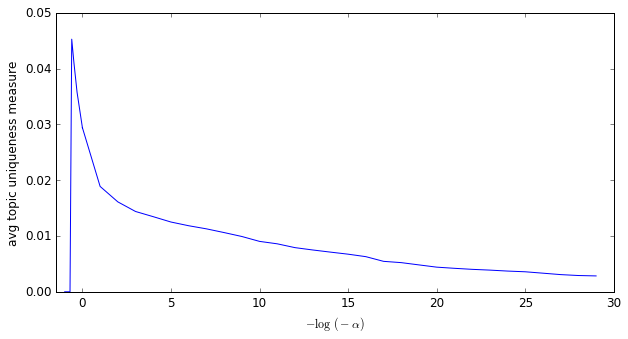

In [27]:
plt.figure(figsize=(10, 5))
plt.xlabel('$- \\log\\ (- \\alpha)$')
plt.ylabel('avg topic uniqueness measure')
plt.plot(minus_log_alphas, avg_uniqueness_measures)
plt.xlim(-1.5, 30)
plt.savefig('/home/tylorn/uniqueness2/sparsity_um_dependency.eps', format='eps')
plt.show()

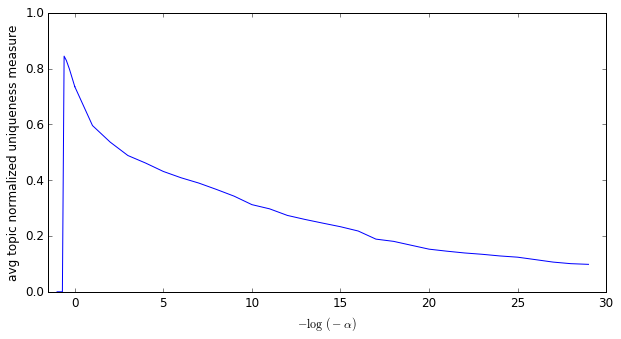

In [28]:
plt.figure(figsize=(10, 5))
plt.xlabel('$- \\log\\ (- \\alpha)$')
plt.ylabel('avg topic normalized uniqueness measure')
plt.plot(minus_log_alphas, avg_normalized_uniqueness_measures)
plt.ylim(0, 1)
plt.xlim(-1.5, 30)
plt.show()

#### Даже небольшого разреживания хватает, чтобы темы стали cущественно уникальными

In [29]:
minus_log_alphas = []
avg_uniqueness_measures2 = []
avg_normalized_uniqueness_measures2 = []
for alpha in alpha_values:
    print alpha
    minus_log_alphas.append(-np.log10(-alpha))
    phi, theta = perform_lda(10, alpha, -0.1)
    ums, nums = calc_phi_uniqueness_measures(phi)
    avg_uniqueness_measures2.append(np.mean(ums))
    avg_normalized_uniqueness_measures2.append(np.mean(nums))

-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
-1
-0.1
-0.01
-0.001
-0.0001
-1e-05
-1e-06
-1e-07
-1e-08
-1e-09
-1e-10
-1e-11
-1e-12
-1e-13
-1e-14
-1e-15
-1e-16
-1e-17
-1e-18
-1e-19
-1e-20
-1e-21
-1e-22
-1e-23
-1e-24
-1e-25
-1e-26
-1e-27
-1e-28
-1e-29


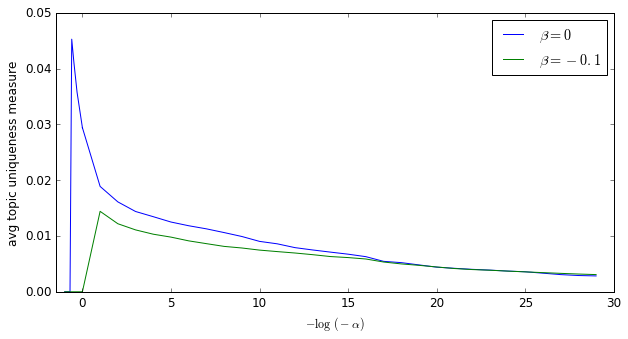

In [30]:
plt.figure(figsize=(10, 5))
plt.xlabel('$- \\log\\ (- \\alpha)$')
plt.ylabel('avg topic uniqueness measure')
plt.xlim(-1.5, 30)
plt.plot(minus_log_alphas, avg_uniqueness_measures)
plt.plot(minus_log_alphas, avg_uniqueness_measures2)
plt.legend(['$\\beta = 0$', '$\\beta = -0.1$', '$\\beta = 0.1$'])
plt.show()

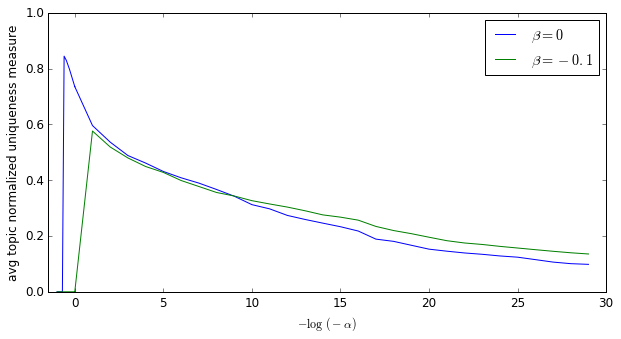

In [31]:
plt.figure(figsize=(10, 5))
plt.xlabel('$- \\log\\ (- \\alpha)$')
plt.ylabel('avg topic normalized uniqueness measure')
plt.ylim(0, 1)
plt.xlim(-1.5, 30)
plt.plot(minus_log_alphas, avg_normalized_uniqueness_measures)
plt.plot(minus_log_alphas, avg_normalized_uniqueness_measures2)
plt.legend(['$\\beta = 0$', '$\\beta = -0.1$', '$\\beta = 0.1$'])
plt.show()

#### Разреживание  $\Theta$ заставляет темы быть более сглаженными, что сказывается негативно на их единственности

In [32]:
minus_log_alphas = []
avg_uniqueness_measures3 = []
avg_normalized_uniqueness_measures3 = []
for alpha in alpha_values:
    print alpha
    minus_log_alphas.append(-np.log10(-alpha))
    phi, theta = perform_lda(10, alpha, 0.1)
    ums, nums = calc_phi_uniqueness_measures(phi)
    avg_uniqueness_measures3.append(np.mean(ums))
    avg_normalized_uniqueness_measures3.append(np.mean(nums))

-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
-1
-0.1
-0.01
-0.001
-0.0001
-1e-05
-1e-06
-1e-07
-1e-08
-1e-09
-1e-10
-1e-11
-1e-12
-1e-13
-1e-14
-1e-15
-1e-16
-1e-17
-1e-18
-1e-19
-1e-20
-1e-21
-1e-22
-1e-23
-1e-24
-1e-25
-1e-26
-1e-27
-1e-28
-1e-29


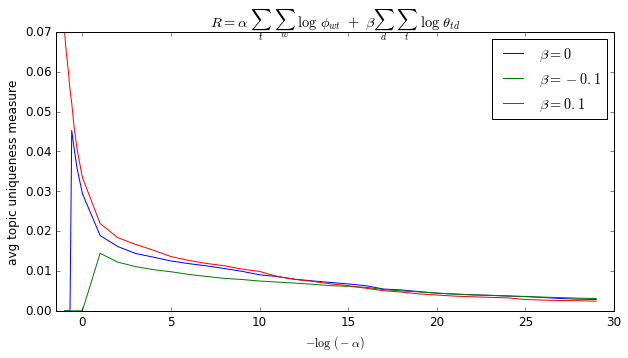

In [33]:
plt.figure(figsize=(10, 5))
plt.title('$R = \\alpha\\ \\sum_t\\ \\sum_w\\ \\log\\ \\phi_{wt}\\ +\\ \\beta \\sum_d\\ \\sum_t\\ \\log\\ \\theta_{td}$')
plt.xlabel('$- \\log\\ (- \\alpha)$')
plt.ylabel('avg topic uniqueness measure')
plt.xlim(-1.5, 30)
plt.plot(minus_log_alphas, avg_uniqueness_measures)
plt.plot(minus_log_alphas, avg_uniqueness_measures2)
plt.plot(minus_log_alphas, avg_uniqueness_measures3)
plt.legend(['$\\beta = 0$', '$\\beta = -0.1$', '$\\beta = 0.1$'])
plt.savefig('/home/tylorn/uniqueness2/sparsity_um_dependency.eps', format='eps')
plt.show()

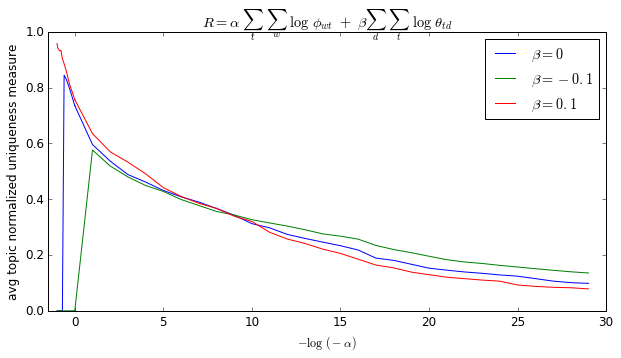

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('$R = \\alpha\\ \\sum_t\\ \\sum_w\\ \\log\\ \\phi_{wt}\\ +\\ \\beta \\sum_d\\ \\sum_t\\ \\log\\ \\theta_{td}$')
plt.xlabel('$- \\log\\ (- \\alpha)$')
plt.ylabel('avg topic normalized uniqueness measure')
plt.ylim(0, 1)
plt.xlim(-1.5, 30)
plt.plot(minus_log_alphas, avg_normalized_uniqueness_measures)
plt.plot(minus_log_alphas, avg_normalized_uniqueness_measures2)
plt.plot(minus_log_alphas, avg_normalized_uniqueness_measures3)
plt.legend(['$\\beta = 0$', '$\\beta = -0.1$', '$\\beta = 0.1$'])
plt.savefig('/home/tylorn/uniqueness2/sparsity_num_dependency.eps', format='eps')
plt.show()

#### Сглаживание  $\Theta$, наоборот, позволяет темам быть более разреженными, что сказывается нменого положительно на их единственности. Однако, так как есть ещё и условие на унитематические документы в теореме, то лучше не пользоваться сглаживанием документов.

In [ ]:
topics_values = []
min_ums_values = []
min_nums_values = []
max_ums_values = []
max_nums_values = []
avg_ums_values = []
avg_nums_values = []
for T in xrange(2, 51):
    print T
    min_ums_value = 0 
    min_nums_value = 0 
    max_ums_value = 0 
    max_nums_value = 0 
    avg_ums_value = 0 
    avg_nums_value = 0 
    
    for seed in xrange(30):
        phi, theta = perform_lda(T, - 0.1, 0., seed=seed)
        dums, dnums = calc_phi_uniqueness_measures(phi)
        
        min_ums_value += np.min(dums) 
        min_nums_value += np.min(dnums) 
        max_ums_value += np.max(dums) 
        max_nums_value += np.max(dnums) 
        avg_ums_value += np.mean(dums) 
        avg_nums_value += np.mean(dnums) 
    
    min_ums_value /= 30 
    min_nums_value /= 30
    max_ums_value /= 30
    max_nums_value /= 30
    avg_ums_value /= 30
    avg_nums_value /= 30
    
    topics_values.append(T)
    min_ums_values.append(min_ums_value)
    min_nums_values.append(min_nums_value)
    max_ums_values.append(max_ums_value)
    max_nums_values.append(max_nums_value)
    avg_ums_values.append(avg_ums_value)
    avg_nums_values.append(avg_nums_value)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44

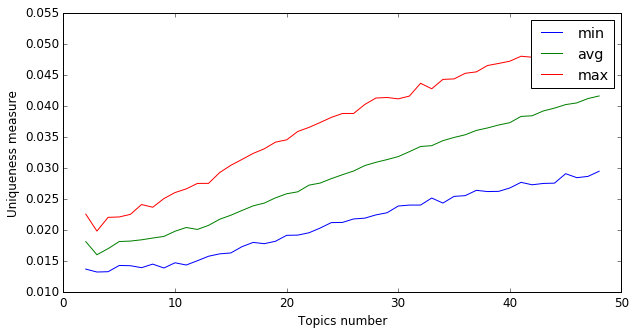

In [37]:
plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Uniqueness measure')
plt.plot(topics_values, min_ums_values)
plt.plot(topics_values, avg_ums_values)
plt.plot(topics_values, max_ums_values)
plt.legend(['min', 'avg', 'max'])
plt.savefig('/home/tylorn/uniqueness2/topics_um_dependency.eps', format='eps')
plt.show()

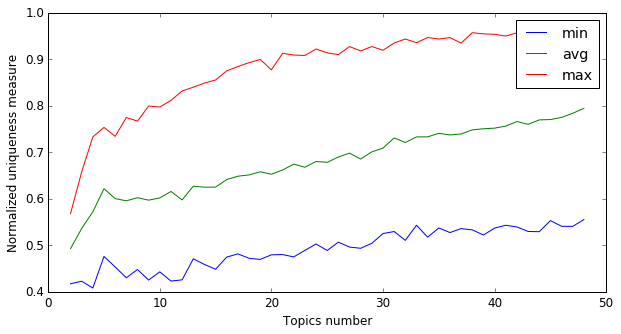

In [38]:
plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Normalized uniqueness measure')
plt.plot(topics_values, min_nums_values)
plt.plot(topics_values, avg_nums_values)
plt.plot(topics_values, max_nums_values)
plt.legend(['min', 'avg', 'max'])
plt.savefig('/home/tylorn/uniqueness2/topics_num_dependency.eps', format='eps')
plt.show()

In [ ]:
def perform_extended_lda(
    T, words_alpha, docs_alpha, seed=42, 
    freq_matrix=origin_freq_matrix, phi_zero_init=None, 
    theta_zero_init=None
):
    D, W = freq_matrix.shape

    np.random.seed(seed)

    phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
    if phi_zero_init is not None:
        phi_matrix[phi_zero_init < 1e-20] = 0.
    phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

    theta_matrix = np.random.uniform(size=(D, T)).astype(np.float64)
    if theta_zero_init is not None:
        theta_zero_init[theta_zero_init < 1e-20] = 0.
    theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

    no_selection_params = {
        'method': perform_e_step_update,
        'block_size': 50,
        'p_dwt_processor': trivial_p_dwt_processor
    }

    regularizations_list = np.zeros(50, dtype=object)
    params_list = np.zeros(50, dtype=object)

    regularizations_list[:10] = trivial_regularization
    regularizations_list[10:] = create_reg_lda(words_alpha, docs_alpha)
    params_list[:] = no_selection_params

    phi, theta = launch_em(
        freq_matrix=freq_matrix, 
        phi_matrix=phi_matrix,
        theta_matrix=theta_matrix,
        regularizations_list=regularizations_list,
        params_list=params_list,
        iters_count=50
    )
    
    return phi, theta

In [ ]:
def plot_tsne(phis, colors, perplexity):
    model = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X = model.fit_transform(phis) 
    plt.figure(figsize=(10, 8))
    plt.xlim(0.95 * min(X[:, 0]), 1.05 * max(X[:, 0]))
    plt.ylim(0.95 * min(X[:, 1]), 1.05 * max(X[:, 1]))
    sc = plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.colorbar(sc)
    plt.show()

In [ ]:
def investigate_matrix_variance(matrices, title_prefix=''):
    smapes = []
    maes = []
    for i in xrange(len(matrices)):
        for j in xrange(len(matrices)):
            if i < j:
                indices = (matrices[i] > 1e-20) | (matrices[j] > 1e-20)
                fst = matrices[i][indices]
                snd = matrices[j][indices]
                smapes.append(np.mean(2. * np.abs(fst - snd) / (np.abs(fst) + np.abs(snd))))
                maes.append(np.mean(np.abs(fst - snd)))
                
    print 'Average pairwise MAE: {}'.format(np.mean(maes))
    print 'Pairwise MAE std: {}'.format(np.std(maes))
    plt.title(title_prefix + ' pairwise MAE distribution')
    plt.hist(maes, bins=50)
    plt.show()
    
    
    print 'Average pairwise sMAPE: {}'.format(np.mean(smapes))
    print 'Pairwise sMAPE std: {}'.format(np.std(smapes))
    plt.title(title_prefix + ' pairwise  sMAPE distribution')
    plt.hist(smapes, bins=50)
    plt.show()

In [ ]:
def investigate_scalar_variance(values, title_prefix=''):
    plt.title(title_prefix + ' value distribution')
    plt.hist(values, bins=50)
    plt.show()
    
    smapes = []
    maes = []
    for i in xrange(len(values)):
        for j in xrange(len(values)):
            if i < j:
                fst = values[i]
                snd = values[j]
                smapes.append(np.mean(2. * np.abs(fst - snd) / (np.abs(fst) + np.abs(snd))))
                maes.append(np.mean(np.abs(fst - snd)))
                
    print 'Average pairwise MAE: {}'.format(np.mean(maes))
    print 'Pairwise MAE std: {}'.format(np.std(maes))
    plt.title(title_prefix + ' pairwise MAE distribution')
    plt.hist(maes, bins=50)
    plt.show()
    
    
    print 'Average pairwise sMAPE: {}'.format(np.mean(smapes))
    print 'Pairwise sMAPE std: {}'.format(np.std(smapes))
    plt.title(title_prefix + ' pairwise sMAPE distribution')
    plt.hist(smapes, bins=50)
    plt.show()

In [ ]:
def smape_dist(a, b):
    indices = (a > 1e-20) | (b > 1e-20)
    fst = a[indices]
    snd = b[indices]
    return np.mean(2. * np.abs(fst - snd) / (np.abs(fst) + np.abs(snd)))

def mae_dist(a, b):
    indices = (a > 1e-20) | (b > 1e-20)
    fst = a[indices]
    snd = b[indices]
    return np.mean(np.abs(fst - snd))

def kl_dist(a, b):
    indices = (a > 1e-20)
    return np.sum(np.log(a[indices] / b[indices]) * a[indices])

def kl2_dist(a, b):
    c = (a + b) / 2.
    return kl_dist(a, c) + kl_dist(b, c)

def greed_match(fst, snd, dst_fun):
    T, W = fst.shape
    dists = []
    for t1 in xrange(T):
        dists.append(min(
            dst_fun(fst[t1, :], snd[t2, :])
            for t2 in xrange(T)
        ))
    return np.array(dists)

In [ ]:
def check_phis(init_phi, phis, title_prefix=''):
    origin_phi = init_phi
    init_phi = init_phi.flatten()
    
    smapes = []
    maes = []
    greed_smapes = []
    greed_maes = []
    
    greed_kls = []
    greed_kl2s = []
    
    for phi in phis:
        indices = (phi > 1e-20) | (init_phi > 1e-20)
        fst = phi[indices]
        snd = init_phi[indices]
        smapes.append(np.mean(2. * np.abs(fst - snd) / (np.abs(fst) + np.abs(snd))))
        maes.append(np.mean(np.abs(fst - snd)))
        
        phi = phi.reshape(origin_phi.shape)
        greed_smapes.append(greed_match(origin_phi, phi, smape_dist))
        greed_maes.append(greed_match(origin_phi, phi, mae_dist))
        
        greed_kls.append(greed_match(origin_phi, phi, kl_dist))
        greed_kl2s.append(greed_match(origin_phi, phi, kl2_dist))
        
    print 'Average MAE: {}'.format(np.mean(maes))
    print 'MAE std: {}'.format(np.std(maes))
    print 'Min MAE: {}'.format(np.min(maes))
    print ''
    print 'Average sMAPE: {}'.format(np.mean(smapes))
    print 'sMAPE std: {}'.format(np.std(smapes))
    print 'Min sMAPE: {}'.format(np.min(smapes))
    print ''
    print 'Average greed MAE: {}'.format(np.mean(greed_maes))
    print 'greed MAE std: {}'.format(np.std(greed_maes))
    print ''
    print 'Average greed sMAPE: {}'.format(np.mean(greed_smapes))
    print 'greed sMAPE std: {}'.format(np.std(greed_smapes))
    print ''
    print 'Average greed KL: {}'.format(np.mean(greed_kls))
    print 'greed KL std: {}'.format(np.std(greed_kls))
    print ''
    print 'Average greed KL2: {}'.format(np.mean(greed_kl2s))
    print 'greed KL2 std: {}'.format(np.std(greed_kl2s))

# Просто обучаем sparse LDA

In [ ]:
%%time
phis = []
perplexities = []
for seed in xrange(300):
    print seed
    phi, theta = perform_extended_lda(10, - 0.1, 0., seed=seed)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(origin_freq_matrix, phi, theta))
phis = np.array(phis)

## sparse LDA: phi points

In [ ]:
plot_tsne(phis, perplexities, 10)

## sparse LDA: phi variance

In [ ]:
investigate_matrix_variance(phis, 'Phi matrix:')

## sparse LDA: perplexity variance

In [ ]:
investigate_scalar_variance(perplexities, 'Perplexity:')

# Обучаем sparse LDA с начальными нулями

In [ ]:
init_phi, init_theta = perform_extended_lda(10, - 0.1, 0., seed=42)

In [ ]:
phis = []
perplexities = []
for seed in xrange(300):
    print seed
    phi, theta = perform_extended_lda(10, - 0.1, 0., seed=seed, phi_zero_init=init_phi, theta_zero_init=init_theta)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(origin_freq_matrix, phi, theta))
phis = np.array(phis)

## full initialized sparse LDA: phi points

In [ ]:
plot_tsne(phis, perplexities, 10)

## full initialized sparse LDA: phi variance

In [ ]:
investigate_matrix_variance(phis, 'Phi matrix:')

## full initialized sparse LDA: perplexity variance

In [ ]:
investigate_scalar_variance(perplexities, 'Perplexity:')

In [ ]:
check_phis(init_phi, phis)

# Syntetic sparse LDA

In [ ]:
m = np.dot(init_theta, init_phi)
print np.sum(np.isnan(m))
m[np.isnan(m)] = 0.
new_freq_matrix = scipy.sparse.csr_matrix(m)

In [ ]:
phis = []
perplexities = []
for seed in xrange(30):
    print seed
    phi, theta = perform_extended_lda(10, - 0.1, 0., seed=seed, freq_matrix=new_freq_matrix)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(new_freq_matrix, phi, theta))
phis = np.array(phis)

## Syntetic sparse LDA: phi points

In [ ]:
plot_tsne(phis, perplexities, 5)

## Syntetic sparse LDA: phi variance

In [ ]:
investigate_matrix_variance(phis)

## Syntetic sparse LDA: perplexity variance

In [ ]:
investigate_scalar_variance(perplexities)

In [ ]:
check_phis(init_phi, phis)

# Full initialized PLSA

In [ ]:
new_init_phi, new_init_theta = perform_extended_lda(10, 0., 0., seed=seed, phi_zero_init=init_phi, theta_zero_init=init_theta)

In [ ]:
phis = []
perplexities = []
for seed in xrange(300):
    print seed
    phi, theta = perform_extended_lda(10, 0., 0., seed=seed, phi_zero_init=new_init_phi, theta_zero_init=new_init_theta)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(origin_freq_matrix, phi, theta))
phis = np.array(phis)

## Full initialized PLSA: phi points

In [ ]:
plot_tsne(phis, perplexities, 10)

## Full initialized PLSA: phi variance

In [ ]:
investigate_matrix_variance(phis)

## Full initialized PLSA: perplexity variance

In [ ]:
investigate_scalar_variance(perplexities)

## Оценим качество приближения

In [ ]:
check_phis(new_init_phi, phis)

# Syntetic PLSA

In [ ]:
m = np.dot(new_init_theta, new_init_phi)
print np.sum(np.isnan(m))
m[np.isnan(m)] = 0.
new_freq_matrix = scipy.sparse.csr_matrix(m)

In [ ]:
phis = []
perplexities = []
for seed in xrange(30):
    print seed
    phi, theta = perform_extended_lda(10, 0., 0., seed=seed, freq_matrix=new_freq_matrix)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(new_freq_matrix, phi, theta))
phis = np.array(phis)

## Full initialized syntetic PLSA: phi points

In [ ]:
plot_tsne(phis, perplexities, 5)

## Full initialized syntetic PLSA: phi variance

In [ ]:
investigate_matrix_variance(phis)

## Full initialized syntetic PLSA: perplexity variance

In [ ]:
investigate_scalar_variance(perplexities)

## Оценим качество приближения

In [ ]:
check_phis(new_init_phi, phis)

# Full initialized syntetic PLSA

In [ ]:
phis = []
perplexities = []
for seed in xrange(30):
    print seed
    phi, theta = perform_extended_lda(10, 0., 0., seed=seed, phi_zero_init=new_init_phi, theta_zero_init=new_init_theta, freq_matrix=new_freq_matrix)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(new_freq_matrix, phi, theta))
phis = np.array(phis)

## Full initialized syntetic PLSA: phi points

In [ ]:
plot_tsne(phis, perplexities, 5)

## Full initialized syntetic PLSA: phi variance

In [ ]:
investigate_matrix_variance(phis)

## Full initialized syntetic PLSA: perplexity variance

In [ ]:
investigate_scalar_variance(perplexities)

## Оценим качество приближения

In [ ]:
check_phis(new_init_phi, phis)

In [ ]:
new_init_phi_, new_init_theta_ = perform_extended_lda(10, 0., 0., seed=seed, phi_zero_init=init_phi, theta_zero_init=init_theta)

In [ ]:
new_init_phi, new_init_theta = perform_extended_lda(10, 0., 0., seed=seed, phi_zero_init=new_init_phi_, theta_zero_init=new_init_theta_)

In [ ]:
m = np.dot(new_init_theta, new_init_phi)
print np.sum(np.isnan(m))
m[np.isnan(m)] = 0.
new_freq_matrix = scipy.sparse.csr_matrix(m)

In [ ]:
phis = []
perplexities = []
for seed in xrange(30):
    print seed
    phi, theta = perform_extended_lda(10, 0., 0., seed=seed, freq_matrix=new_freq_matrix)
    phis.append(phi.flatten())
    perplexities.append(external_calculate_perplexity(new_freq_matrix, phi, theta))
phis = np.array(phis)

In [ ]:
investigate_matrix_variance(phis)

In [ ]:
check_phis(new_init_phi, phis)

In [ ]:
topics_values1 = []
perplexity_values1 = []
for T in xrange(2, 51):
    p = 0.
    for seed in xrange(3):
        phi, theta = perform_lda(T, - 0.1, 0., seed=seed)
        p += external_calculate_perplexity(origin_freq_matrix, phi, theta)
    p /= 3
    
    topics_values1.append(T)
    perplexity_values1.append(p)
    
    print T, p
perplexity_values1 = np.array(perplexity_values1)

In [ ]:
plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Normalized uniqueness measure')
plt.plot(topics_values, min_nums_values)
plt.plot(topics_values, avg_nums_values)
plt.plot(topics_values, max_nums_values)
plt.plot(topics_values1, perplexity_values1 / np.max(perplexity_values1))
plt.legend(['min', 'avg', 'max'])
plt.show()

In [39]:
import pickle

with open('6_topics_dependency.pkl', 'w') as f:
    pickle.dump({
        'avg_nums_value': avg_nums_value,
        'min_nums_value': min_nums_value,
        'max_nums_value': max_nums_value,
        'avg_ums_value': avg_ums_value,
        'min_ums_value': min_ums_value,
        'max_ums_value': max_ums_value,
        #'perplexity_values': perplexity_values1
    }, f)

In [41]:
topics_values2 = []
min_ums_values2 = []
min_nums_values2 = []
max_ums_values2 = []
max_nums_values2 = []
avg_ums_values2 = []
avg_nums_values2 = []
for T in xrange(10, 101, 10):
    print T
    min_ums_value = 0 
    min_nums_value = 0 
    max_ums_value = 0 
    max_nums_value = 0 
    avg_ums_value = 0 
    avg_nums_value = 0 
    
    for seed in xrange(1):
        phi, theta = perform_lda(T, - 0.1, 0., seed=seed)
        dums, dnums = calc_phi_uniqueness_measures(phi)
        
        min_ums_value += np.min(dums) 
        min_nums_value += np.min(dnums) 
        max_ums_value += np.max(dums) 
        max_nums_value += np.max(dnums) 
        avg_ums_value += np.mean(dums) 
        avg_nums_value += np.mean(dnums) 
    
    min_ums_value /= 1 
    min_nums_value /= 1
    max_ums_value /= 1
    max_nums_value /= 1
    avg_ums_value /= 1
    avg_nums_value /= 1
    
    topics_values2.append(T)
    min_ums_values2.append(min_ums_value)
    min_nums_values2.append(min_nums_value)
    max_ums_values2.append(max_ums_value)
    max_nums_values2.append(max_nums_value)
    avg_ums_values2.append(avg_ums_value)
    avg_nums_values2.append(avg_nums_value)
    
    print min_nums_values2


10
[0.30216149099066564]
20
[0.30216149099066564, 0.45180727863654602]
30
[0.30216149099066564, 0.45180727863654602, 0.51511767314071477]
40
[0.30216149099066564, 0.45180727863654602, 0.51511767314071477, 0.55133014083348042]
50
[0.30216149099066564, 0.45180727863654602, 0.51511767314071477, 0.55133014083348042, 0.59979735700323467]
60
[0.30216149099066564, 0.45180727863654602, 0.51511767314071477, 0.55133014083348042, 0.59979735700323467, 0.61192756567644979]
70
[0.30216149099066564, 0.45180727863654602, 0.51511767314071477, 0.55133014083348042, 0.59979735700323467, 0.61192756567644979, 0.56217971556569957]
80


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Normalized uniqueness measure')
plt.plot(topics_values, min_nums_values)
plt.plot(topics_values, avg_nums_values)
plt.plot(topics_values, max_nums_values)
plt.legend(['min', 'avg', 'max'])
plt.show()

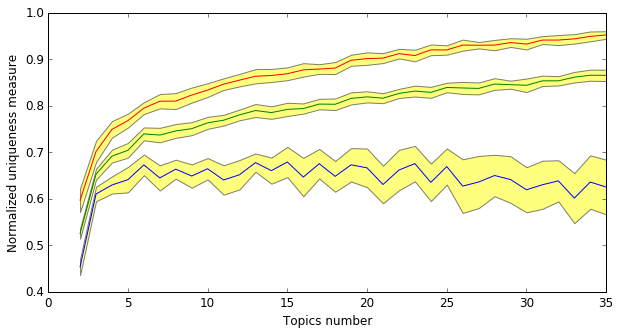

In [60]:
import pickle

with open('/home/tylorn/uniqueness_glob/topics_dependency_origin_1.pkl', 'r') as f:
    d = pickle.load(f)

def m_plot(val_name, err_name):
    val = np.array(d[val_name])
    err = np.array(d[err_name])
    
    plt.plot(d['topics_values'], val)
    plt.fill_between(d['topics_values'], val - err, val + err, alpha=0.5, facecolor='yellow')
    
val = np.array(d['min_nums_values'])
err = np.array(d['min_nums_values_err'])

plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Normalized uniqueness measure')

m_plot('min_nums_values', 'min_nums_values_err')
m_plot('avg_nums_values', 'avg_nums_values_err')
m_plot('max_nums_values', 'max_nums_values_err')

plt.show()

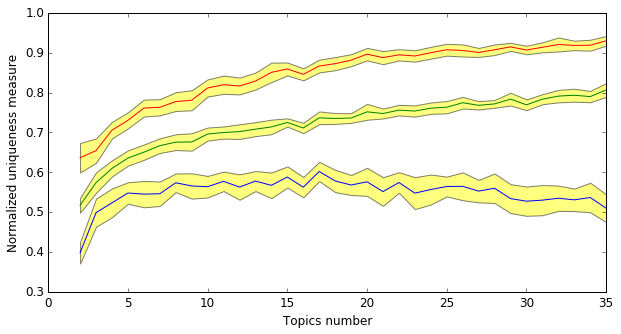

In [61]:
import pickle

with open('/home/tylorn/uniqueness_glob/topics_dependency_origin_2.pkl', 'r') as f:
    d = pickle.load(f)

def m_plot(val_name, err_name):
    val = np.array(d[val_name])
    err = np.array(d[err_name])
    
    plt.plot(d['topics_values'], val)
    plt.fill_between(d['topics_values'], val - err, val + err, alpha=0.5, facecolor='yellow')
    
val = np.array(d['min_nums_values'])
err = np.array(d['min_nums_values_err'])

plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Normalized uniqueness measure')

m_plot('min_nums_values', 'min_nums_values_err')
m_plot('avg_nums_values', 'avg_nums_values_err')
m_plot('max_nums_values', 'max_nums_values_err')

plt.show()

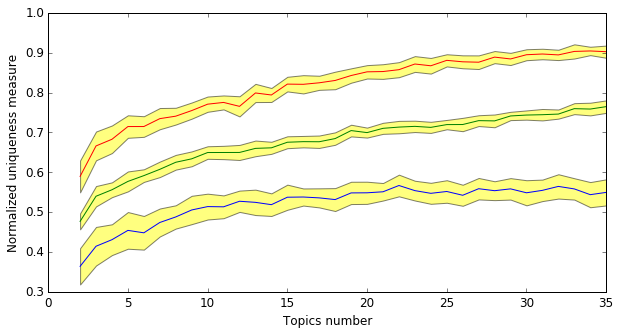

In [66]:
import pickle

with open('/home/tylorn/uniqueness_glob/topics_dependency_origin_3.pkl', 'r') as f:
    d = pickle.load(f)

def m_plot(val_name, err_name):
    val = np.array(d[val_name])
    err = np.array(d[err_name])
    
    plt.plot(d['topics_values'], val)
    plt.fill_between(d['topics_values'], val - err, val + err, alpha=0.5, facecolor='yellow')
    
val = np.array(d['min_nums_values'])
err = np.array(d['min_nums_values_err'])

plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Normalized uniqueness measure')

m_plot('min_nums_values', 'min_nums_values_err')
m_plot('avg_nums_values', 'avg_nums_values_err')
m_plot('max_nums_values', 'max_nums_values_err')

plt.show()

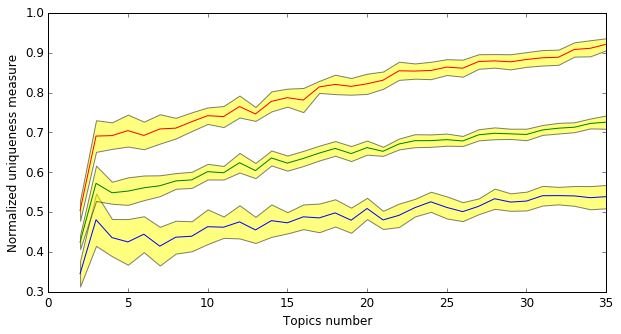

In [67]:
import pickle

with open('/home/tylorn/uniqueness_glob/topics_dependency_origin_4.pkl', 'r') as f:
    d = pickle.load(f)

def m_plot(val_name, err_name):
    val = np.array(d[val_name])
    err = np.array(d[err_name])
    
    plt.plot(d['topics_values'], val)
    plt.fill_between(d['topics_values'], val - err, val + err, alpha=0.5, facecolor='yellow')
    
val = np.array(d['min_nums_values'])
err = np.array(d['min_nums_values_err'])

plt.figure(figsize=(10, 5))
plt.xlabel('Topics number')
plt.ylabel('Normalized uniqueness measure')

m_plot('min_nums_values', 'min_nums_values_err')
m_plot('avg_nums_values', 'avg_nums_values_err')
m_plot('max_nums_values', 'max_nums_values_err')

plt.show()

In [109]:
import random

def prepare_train_test_dataset(dataset):
    # remove stopwords
    occurences = Counter()
    for i, doc in enumerate(dataset.data):
        tokens = gensim.utils.lemmatize(doc)
        for token in set(tokens):
            occurences[token] += 1
        if i % 500 == 0:
            print 'Processed: ', i, 'documents from', len(dataset.data)
    
    train_row, train_col, train_data = [], [], []
    test_row, test_col, test_data = [], [], []
    token_2_num = {}
    for i, doc in enumerate(dataset.data):
        tokens = gensim.utils.lemmatize(doc)
        cnt_train = Counter()
        cnt_test = Counter()
        for token in tokens:
            word = token.split('/')[0]
            if word not in english_stopwords and 10 <= occurences[token] < len(dataset.data) / 2:
                if token not in token_2_num:
                    token_2_num[token] = len(token_2_num)
                if random.random() < 0.05:
                    cnt_test[token_2_num[token]] += 1
                else:
                    cnt_train[token_2_num[token]] += 1
        for w, c in cnt_test.iteritems():
            test_row.append(i)
            test_col.append(w)
            test_data.append(c)
        for w, c in cnt_train.iteritems():
            train_row.append(i)
            train_col.append(w)
            train_data.append(c)
        
    num_2_token = {
        v: k
        for k, v in token_2_num.iteritems()
    }
    return (
        scipy.sparse.csr_matrix((train_data, (train_row, train_col))),
        scipy.sparse.csr_matrix((test_data, (test_row, test_col))),
        token_2_num,
        num_2_token
    )


In [128]:
dataset2 = fetch_20newsgroups(
    subset='all',
    categories=['sci.electronics', 'sci.space', 'sci.med'],
    remove=('headers', 'footers', 'quotes')
)

In [129]:
%%time
train_origin_freq_matrix, test_origin_freq_matrix, _, _ = prepare_train_test_dataset(dataset2)

Processed:  0 documents from 2961
Processed:  500 documents from 2961
Processed:  1000 documents from 2961
Processed:  1500 documents from 2961
Processed:  2000 documents from 2961
Processed:  2500 documents from 2961
CPU times: user 0 ns, sys: 2min 7s, total: 2min 7s
Wall time: 2min 7s


In [130]:
D, W = train_origin_freq_matrix.shape

In [135]:
print train_origin_freq_matrix.shape

(2961, 3289)


In [132]:
test_origin_freq_matrix

<2961x3287 sparse matrix of type '<type 'numpy.int64'>'
	with 9308 stored elements in Compressed Sparse Row format>

In [133]:
topics_values1 = []
train_perplexity_values1 = []
test_perplexity_values1 = []
for T in xrange(2, 36):
    p_train = 0.
    p_test = 0.
    for seed in xrange(3):
        phi, theta = perform_lda(T, - 0.1, 0., seed=seed, freq_matrix=train_origin_freq_matrix)
        theta[np.isnan(theta)] = 1e-20
        theta /= np.sum(theta, axis=1)[:, np.newaxis]
        p_train += external_calculate_perplexity(train_origin_freq_matrix, phi, theta)
        p_test += external_calculate_perplexity(test_origin_freq_matrix, phi, theta)
    p_train /= 3
    p_test /= 3
    
    topics_values1.append(T)
    train_perplexity_values1.append(p_train)
    test_perplexity_values1.append(p_test)
    
    print T, p_train, p_test
    
train_perplexity_values1 = np.array(train_perplexity_values1)
test_perplexity_values1 = np.array(test_perplexity_values1)

2 1549.50889697 1692.19224216
3 1416.73689174 1627.91688006
4 1300.72748997 1596.63808255
5 1252.98467522 1639.96950201
6 1185.06859987 1583.14643462
7 1152.02789785 1589.50994703
8 1112.00350076 1637.4586821
9 1081.96691887 1644.40247117
10 1050.31194298 1658.89952194
11 1010.07203763 1642.18551766
12 1009.44147819 1730.5099764
13 974.11468558 1698.15128035
14 962.968577465 1765.36098121
15 940.611590481 1741.80370549
16 927.433393212 1734.50312175
17 920.513058594 1887.17010184
18 905.785271434 1881.22239358
19 890.570627576 1856.58965589
20 879.000523743 1923.24457188
21 862.485544214 2048.84794647
22 855.596998537 1994.72927933


KeyboardInterrupt: 